In [1]:
#Change directory to data location
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats

In [4]:
#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')

In [5]:
#Date event CENS CS no CS (1-->CS, 0-->no CS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = censevt[censevt['cs event'] == i].index
    print("Number of CENS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(censevt)))
    print("Number of CENS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(censevt.index))))
    evt_cens_cs.append(evt_cens.values)

Number of CENS 0 = 48 dari 117
Number of CENS 0 = 41.02564102564103%
Number of CENS 1 = 69 dari 117
Number of CENS 1 = 58.97435897435897%


In [6]:
#Read data
datavimtu = xr.open_mfdataset('vimtu\*.nc',combine = 'by_coords')
datavimtv = xr.open_mfdataset('vimtv\*.nc',combine = 'by_coords')
datavimtc=xr.open_dataset('DataVIMCERA5.nc')

In [7]:
vimtu=datavimtu['p71.162'].sel(lat=slice(-20,20), lon=slice(90,130), time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
vimtv=datavimtv['p72.162'].sel(lat=slice(-20,20), lon=slice(90,130), time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))
vimtc=datavimtc['div'].sel(lat=slice(-20,20), lon=slice(90,130), time=slice('1979-11-01T00:00:00.000000000','2020-03-31T00:00:00.000000000'))

#Slice in NDJFM
vimtu=vimtu.rolling(time=3, center=True).mean().sel(time=vimtu.time.dt.month.isin([1, 2, 3, 11, 12]))
vimtv=vimtv.rolling(time=3, center=True).mean().sel(time=vimtv.time.dt.month.isin([1, 2, 3, 11, 12]))
vimtc=vimtc.rolling(time=3, center=True).mean().sel(time=vimtc.time.dt.month.isin([1, 2, 3, 11, 12]))

#Calculate clim and rainfall anomalies
climvimtu = vimtu.sel(time=vimtu.time.dt.season=="DJF").mean('time')
anvimtundjfm = vimtu - climvimtu
climvimtv = vimtv.sel(time=vimtv.time.dt.season=="DJF").mean('time')
anvimtvndjfm = vimtv - climvimtv
climvimtc = vimtc.sel(time=vimtc.time.dt.season=="DJF").mean('time')
anvimtcndjfm = vimtc - climvimtc

In [8]:
#Get the variables
lat=vimtu['lat'].values
lon=vimtu['lon'].values
#time=anvimtu['time'].values

In [9]:
vimtudjfclim= xr.Dataset(
     {"vimtu": (("time","lat","lon"), anvimtundjfm.values)},
    coords={
    "time": anvimtundjfm['time'],    
    "lat": lat,
    "lon": lon},
    )

In [10]:
vimtvdjfclim= xr.Dataset(
     {"vimtv": (("time","lat","lon"), anvimtvndjfm.values)},
    coords={
    "time": anvimtvndjfm['time'],    
    "lat": lat,
    "lon": lon},
    )

In [11]:
vimtcdjfclim= xr.Dataset(
     {"div": (("time","lat","lon"), anvimtcndjfm.values)},
    coords={
    "time": anvimtcndjfm['time'],    
    "lat": lat,
    "lon": lon},
    )

In [12]:
#Change CS and no-CS array for plot
evt_cens_cs=[evt_cens_cs[1], evt_cens_cs[0]]

In [13]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [14]:
sigvimtc=np.empty([2, 5, len(lat), len(lon)], dtype='bool')
data=vimtcdjfclim['div'].sel(time=vimtcdjfclim.time.dt.season=="DJF")
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    for d, n in zip([-4,-2,0,2,4], range(5)):
        compositemean=vimtcdjfclim['div'].sel(time=np.in1d(vimtcdjfclim.time, evt_cens_cs[c]+np.timedelta64(d,'D'))).mean(dim='time')
        sigvimtc[c, n]=np.logical_or(compositemean<low, compositemean>high).values
pvaluevimtctf=sigvimtc

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.04it/s]


In [15]:
sigvimtu=np.empty([2, 5, len(lat), len(lon)], dtype='bool')
data=vimtudjfclim['vimtu'].sel(time=vimtudjfclim.time.dt.season=="DJF")
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    for d, n in zip([-4,-2,0,2,4], range(5)):
        compositemean=vimtudjfclim['vimtu'].sel(time=np.in1d(vimtudjfclim.time, evt_cens_cs[c]+np.timedelta64(d,'D'))).mean(dim='time')
        sigvimtu[c, n]=np.logical_or(compositemean<low, compositemean>high).values
pvaluevimtutf=sigvimtu

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.66it/s]


In [16]:
sigvimtv=np.empty([2, 5, len(lat), len(lon)], dtype='bool')
data=vimtvdjfclim['vimtv'].sel(time=vimtvdjfclim.time.dt.season=="DJF")
for c in range(2):
    low, high = bootstrap_3dxr(data, len(evt_cens_cs[c]), 1000, 1)
    for d, n in zip([-4,-2,0,2,4], range(5)):
        compositemean=vimtvdjfclim['vimtv'].sel(time=np.in1d(vimtvdjfclim.time, evt_cens_cs[c]+np.timedelta64(d,'D'))).mean(dim='time')
        sigvimtv[c, n]=np.logical_or(compositemean<low, compositemean>high).values
pvaluevimtvtf=sigvimtv

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.80it/s]


In [17]:
pvaluevimtuvtf=np.logical_or(pvaluevimtutf, pvaluevimtvtf)
pvaluevimtuvtf=pvaluevimtuvtf.astype(float)
pvaluevimtuvtf[pvaluevimtuvtf==0] = np.nan

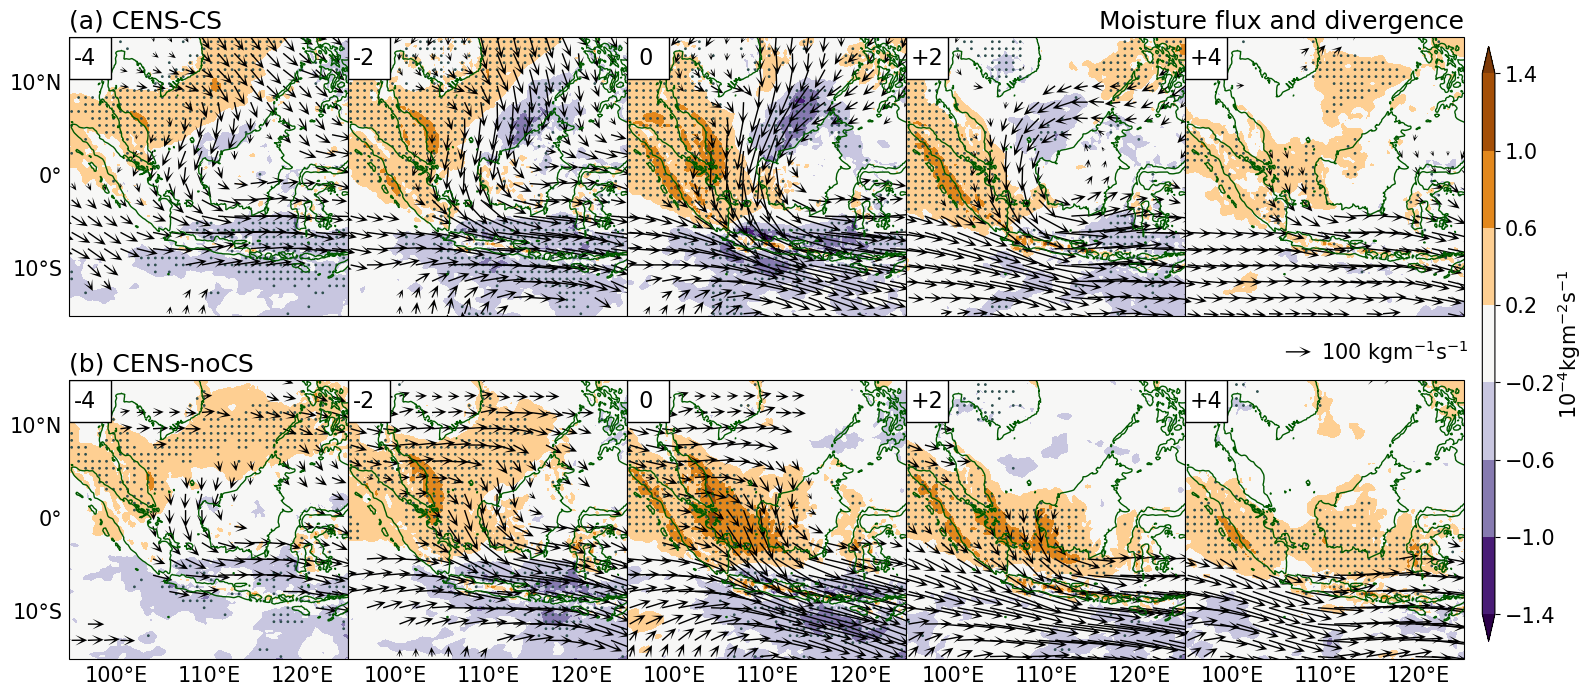

In [22]:
#Plot Moisture Flux and Convergence
fig, axs = plt.subplots(nrows=2,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8.5))

for k in range(2):
    for j, i, text in zip([-4,-2,0,2,4], range(5), ['-4','-2',' 0','+2','+4']):
       
        axs[k,i].set_extent([95, 125, -15, 15])
        gl=axs[k,i].gridlines(draw_labels=True,linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = tk.FixedLocator([100, 110, 120])
        gl.ylocator = tk.FixedLocator([-10, 0, 10])
        gl.xlabel_style = {'size': 15}
        gl.ylabel_style = {'size': 15}
        if k==0:
            gl.bottom_labels = False
        if i>0:
            gl.left_labels = False
        valuetp=vimtcdjfclim['div'].sel(time=np.in1d(vimtcdjfclim.time, evt_cens_cs[k]+np.timedelta64(j,'D'))).mean(dim='time')
        plotvaltp=axs[k,i].contourf(lon, lat, valuetp*10000, transform=ccrs.PlateCarree(),
                  cmap='PuOr_r',
                  levels=np.arange(-1.4,1.5,0.4), 
                  extend='both'
                  )
            
        x,y=np.meshgrid(lon, lat)
        
        skipp=3
        axs[k,i].scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluevimtctf[k,i][::skipp,::skipp]*1,color='darkslategrey', linewidth=1)

        uu=vimtudjfclim['vimtu'].sel(time=np.in1d(vimtudjfclim.time, evt_cens_cs[k]+np.timedelta64(j,'D'))).mean(dim='time')
        vv=vimtvdjfclim['vimtv'].sel(time=np.in1d(vimtvdjfclim.time, evt_cens_cs[k]+np.timedelta64(j,'D'))).mean(dim='time')
        skip = 7
        Qwdg=axs[k,i].quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvaluevimtuvtf[k,i][::skip, ::skip], vv[::skip, ::skip]*pvaluevimtuvtf[k,i][::skip, ::skip], color='k', scale=400 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)

        axs[k,i].add_feature(cfeature.COASTLINE, edgecolor='#005a00', zorder=1)
        longitude1, latitude1 = 95, 10.5
        longitude2, latitude2 = 99.5, 15

        axs[k,i].add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                        facecolor='white', edgecolor='k', linewidth=1,
                                        transform=ccrs.PlateCarree()))
        
        axs[k,i].text(95.5,12,text,fontsize=16, c='k')
        
        if i==0 and k==0:
            axs[k,i].set_title('(a) CENS-CS', loc='left', fontsize=18,
                    )
        if i==0 and k==1:
            axs[k,i].set_title('(b) CENS-noCS', loc='left', fontsize=18,
                    )
        if i==4 and k==0:
            axs[k,i].set_title('Moisture flux and divergence', loc='right', fontsize=18,
                    )
            

        if k==1 and i==4:
            qk = plt.quiverkey(Qwdg, 
                  0.45, 1.1,                  
                  100,str(100)+' $\mathregular{kgm^{-1}s^{-1}}$',   
                  labelpos='E',               
                  coordinates='axes', fontproperties={'size':15}
                   )

cbar_tp = fig.add_axes([0.91, 0.15, 0.007, 0.7])
cbartp = fig.colorbar(plotvaltp, cax=cbar_tp)
cbartp.ax.tick_params(labelsize=15)
cbartp.ax.set_ylabel('$\mathregular{10^{-4}kgm^{-2}s^{-1}}$', fontsize=15, labelpad=0)

fig.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('figure_output\Fig 6.pdf', bbox_inches='tight')
plt.show()